# **Introduction**

The retail industry faces the challenge of understanding customer behavior to enhance targeted marketing strategies. Customer segmentation, a technique where customers are grouped based on similar characteristics, is essential for tailoring marketing efforts and improving customer satisfaction. This notebook focuses on performing customer segmentation using unsupervised learning techniques, specifically K-Means and Hierarchical Clustering. By analyzing an online retail dataset, the aim is to identify distinct customer groups based on their purchasing behavior, which can then be leveraged for personalized marketing strategies.

In [ ]:
#import libraries

#general libraries
import numpy as np
import pandas as pd
import datetime as dt

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#model development
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [ ]:
clust = pd.read_csv('/content/OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
clust.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom


In this initial step, the dataset is imported and thoroughly examined to gain a comprehensive understanding of its structure and content. The dataset used in this analysis comprises transactional data from an online retail store, including key variables such as InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, and Country. The first task involves inspecting the data types, identifying any missing values, and assessing the general quality of the data. This step is crucial for laying the foundation for further analysis, as it ensures that the data is clean, well-structured, and ready for the application of machine learning algorithms. Basic statistics and preliminary visualizations are employed to highlight the distribution of transactions and to provide insights into customer purchasing behavior, which will guide the subsequent exploratory data analysis and modeling phases.

In [ ]:
clust.shape

(394982, 8)

In [ ]:
clust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394982 entries, 0 to 394981
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    394982 non-null  object 
 1   StockCode    394982 non-null  object 
 2   Description  393664 non-null  object 
 3   Quantity     394981 non-null  float64
 4   InvoiceDate  394981 non-null  object 
 5   UnitPrice    394981 non-null  float64
 6   CustomerID   293037 non-null  float64
 7   Country      394981 non-null  object 
dtypes: float64(3), object(5)
memory usage: 24.1+ MB


In [ ]:
clust.describe()

,Quantity,UnitPrice,CustomerID
count,394981.000000,394981.000000,293037.000000
mean,9.802039,4.725367,15273.040572
std,176.162582,104.248717,1718.775810
min,-74215.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13871.000000
50%,3.000000,2.100000,15144.000000
75%,11.000000,4.130000,16782.000000
max,74215.000000,38970.000000,18287.000000


# **Exploratory Data Analysis**

### **Data Cleansing**

The data preparation step involves transforming the raw dataset into a structured format suitable for clustering analysis. This process begins with handling missing values, particularly focusing on the CustomerID field, which is essential for customer segmentation. Rows with missing CustomerID values are removed to ensure the integrity of the analysis. Additionally, the dataset is filtered to include only relevant transactions, such as removing canceled orders and correcting any anomalies in the data. To streamline the analysis, new features are engineered, including the total monetary value per transaction. These preparations ensure that the data is clean, consistent, and ready for the application of RFM (Recency, Frequency, Monetary) analysis, which forms the basis for clustering.

In [ ]:
# Calculating the Missing Values % contribution in DF
df_null = round(100*(clust.isnull().sum())/len(clust), 2)
df_null

,0
InvoiceNo,0.00
StockCode,0.00
Description,0.33
Quantity,0.00
InvoiceDate,0.00
UnitPrice,0.00
CustomerID,25.81
Country,0.00


In [ ]:
# Dropping rows having missing values
clust = clust.dropna()
clust.shape

(293037, 8)

In [ ]:
# Changing the datatype of Customer Id as per Business understanding
clust['CustomerID'] = clust['CustomerID'].astype(str)

### **Data Preparation**

RFM Analysis is a pivotal method for customer segmentation, focusing on three key behavioral metrics: Recency, Frequency, and Monetary value. Each of these metrics provides critical insights into a customer’s interaction with the business. Recency measures the time since the customer’s last purchase, offering insights into their engagement level. Customers who made recent purchases are considered more engaged and likely to respond to marketing efforts. Frequency captures the number of purchases made within a specific period, indicating customer loyalty and the strength of their relationship with the brand. High-frequency customers are generally more loyal and valuable. Monetary value assesses the total amount spent by a customer, reflecting their overall contribution to revenue.

In this step, the dataset is first aggregated at the customer level, where each customer's transactions are summarized to calculate their Recency, Frequency, and Monetary values. The Recency metric is computed by finding the difference between the most recent transaction date and a reference point (often the last date in the dataset), giving a clear picture of how recently a customer has engaged with the business. Frequency is derived by counting the total number of unique transactions per customer, providing an understanding of how often they purchase. Finally, the Monetary value is calculated by summing the total amount spent by each customer across all their transactions, highlighting those who contribute the most financially.

Once the RFM scores are calculated, they are typically scaled or ranked to ensure comparability across customers. These scores are then used to segment customers into different groups based on their purchasing behavior. For instance, customers with high Recency, Frequency, and Monetary scores are classified as high-value customers, while those with low scores might be at risk of churning. This segmentation is visualized through histograms and other charts, allowing for an intuitive understanding of the distribution and significance of each RFM component within the customer base. The RFM analysis not only aids in identifying key customer segments but also lays the groundwork for the subsequent clustering analysis, where these metrics are used to create distinct customer groups that can be targeted with tailored marketing strategies.








In [ ]:
# New Attribute : Monetary

clust['Amount'] = clust['Quantity']*clust['UnitPrice']
rfm_m = clust.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,2790.86
2,12348.0,1797.24
3,12350.0,334.40
4,12352.0,1233.68


In [ ]:
# New Attribute : Frequency

rfm_f = clust.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,124
2,12348.0,31
3,12350.0,17
4,12352.0,80


In [ ]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,2790.86,124
2,12348.0,1797.24,31
3,12350.0,334.40,17
4,12352.0,1233.68,80


In [ ]:
# New Attribute : Recency

# Convert to datetime to proper datatype

clust['InvoiceDate'] = pd.to_datetime(clust['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [ ]:
# Compute the maximum date to know the last transaction date

max_date = max(clust['InvoiceDate'])
max_date

Timestamp('2011-10-13 10:57:00')

In [ ]:
# Compute the difference between max date and transaction date

clust['Diff'] = max_date - clust['InvoiceDate']
clust.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,316 days 02:31:00
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,316 days 02:31:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,316 days 02:31:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,316 days 02:31:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,316 days 02:31:00


In [ ]:
# Compute last transaction date to get the recency of customers

rfm_p = clust.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,268 days 00:40:00
1,12347.0,72 days 02:09:00
2,12348.0,17 days 21:44:00
3,12350.0,252 days 18:56:00
4,12352.0,14 days 19:59:00


In [ ]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,268
1,12347.0,72
2,12348.0,17
3,12350.0,252
4,12352.0,14


In [ ]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,268
1,12347.0,2790.86,124,72
2,12348.0,1797.24,31,17
3,12350.0,334.40,17,252
4,12352.0,1233.68,80,14


Outlier Analysis

Text(0.5, 0, 'Attributes')

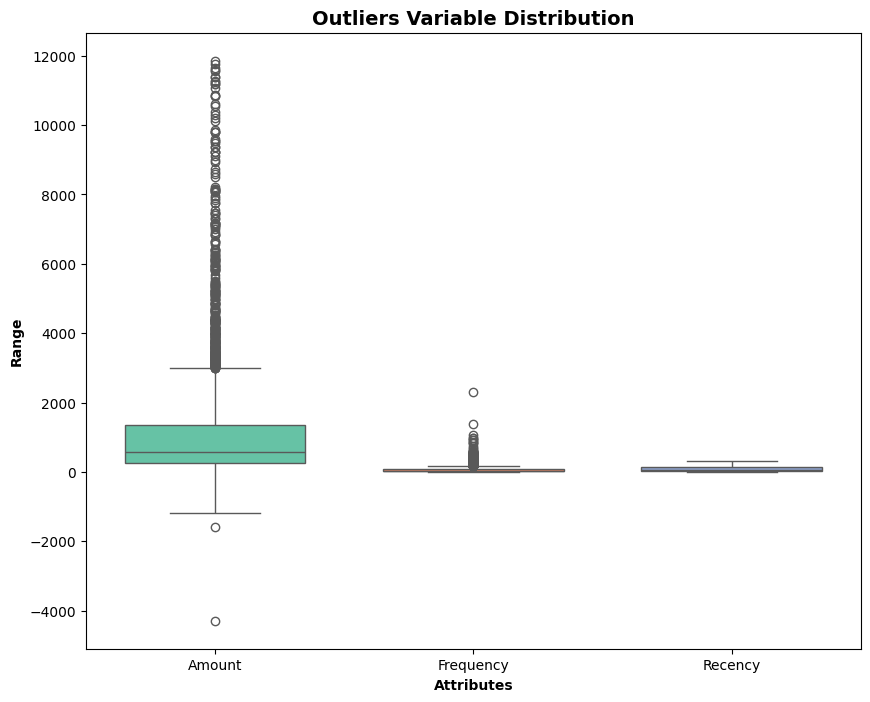

In [ ]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1

**Normalizing the Variables**

To ensure that variables are on a comparable scale, normalization is crucial. Two prevalent methods for normalization include:

Min-Max Scaling
Standardization (mean=0, standard deviation=1)
For this context, we will employ Standardization.

In [ ]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3736, 3)

In [ ]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.758554,-0.653394,1.927834
1,1.182203,0.558164,-0.233353
2,0.491242,-0.365401,-0.839809
3,-0.526013,-0.504432,1.751411
4,0.099344,0.121208,-0.872888


# **Model Building**

For customer segmentation, two distinct clustering algorithms—K-Means and Hierarchical Clustering—are utilized to achieve comprehensive insights into customer behavior.

### **K-Means**

Initially, K-Means clustering is applied to partition customers into distinct clusters based on their Recency, Frequency, and Monetary (RFM) values. To determine the optimal number of clusters for K-Means, the Elbow method is employed, which involves plotting the within-cluster sum of squares (WCSS) against the number of clusters and identifying the "elbow" point where the rate of decrease sharply changes. This approach ensures that the number of clusters chosen balances the trade-off between cluster variance and model complexity. Subsequently, customers are assigned to clusters that best represent their RFM profiles, facilitating the identification of specific customer groups with similar purchasing behaviors.

In [ ]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=50, n_clusters=4)

In [ ]:
kmeans.labels_

array([2, 3, 0, ..., 0, 3, 0], dtype=int32)

**Elbow Method**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

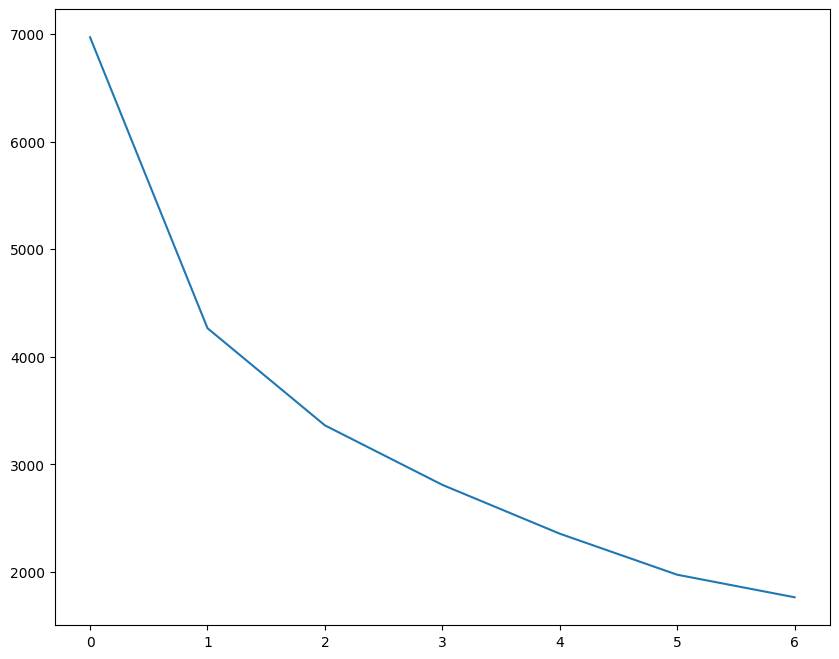

In [ ]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(ssd)

**Silhouette Analysis**

In addition to the Elbow method, Silhouette Analysis is used to evaluate the quality of clustering. The silhouette score is calculated using the formula:

silhouette score
=
𝑝
−
𝑞
/
max
⁡
(
𝑝
,
𝑞
)

​


where
𝑝
 represents the mean distance to the points in the nearest cluster that the data point is not a part of, and
𝑞
 represents the mean intra-cluster distance to all the points in its own cluster. The silhouette score ranges from -1 to 1, with a score closer to 1 indicating that the data point is very similar to other data points in its cluster, and a score closer to -1 indicating that the data point is not similar to the points in its cluster. This metric provides an additional layer of validation for the clustering results, helping to ensure that the clusters are well-separated and meaningful.

In [ ]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=2, the silhouette score is 0.5348903923987695


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=3, the silhouette score is 0.4734701605929308


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=4, the silhouette score is 0.4594778800067269


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=5, the silhouette score is 0.46027406612844307


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=6, the silhouette score is 0.4040321606298201


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=7, the silhouette score is 0.40959100764289674


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters=8, the silhouette score is 0.38805964889425604


In [ ]:

# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=50, n_clusters=3)

In [ ]:
 kmeans.labels_

array([2, 1, 1, ..., 1, 0, 1], dtype=int32)

In [ ]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,268,2
1,12347.0,2790.86,124,72,1
2,12348.0,1797.24,31,17,1
3,12350.0,334.40,17,252,2
4,12352.0,1233.68,80,14,1


**Visualizing ClusterID vs Amount, Frequency and Recency(RFM) for K-Means**

<Axes: xlabel='Cluster_Id', ylabel='Amount'>

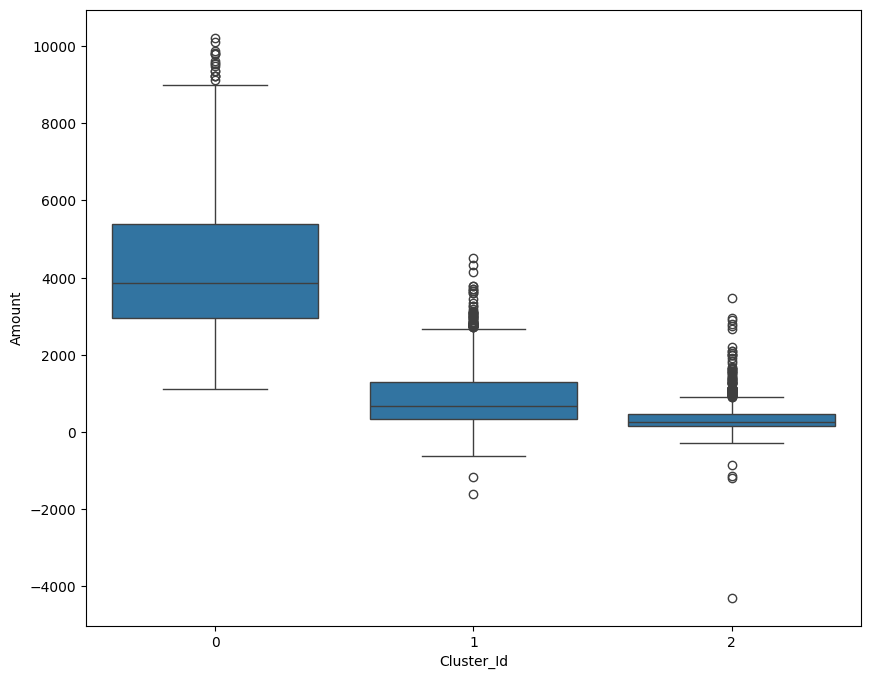

In [ ]:
# Box plot to visualize Cluster Id vs Amount

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

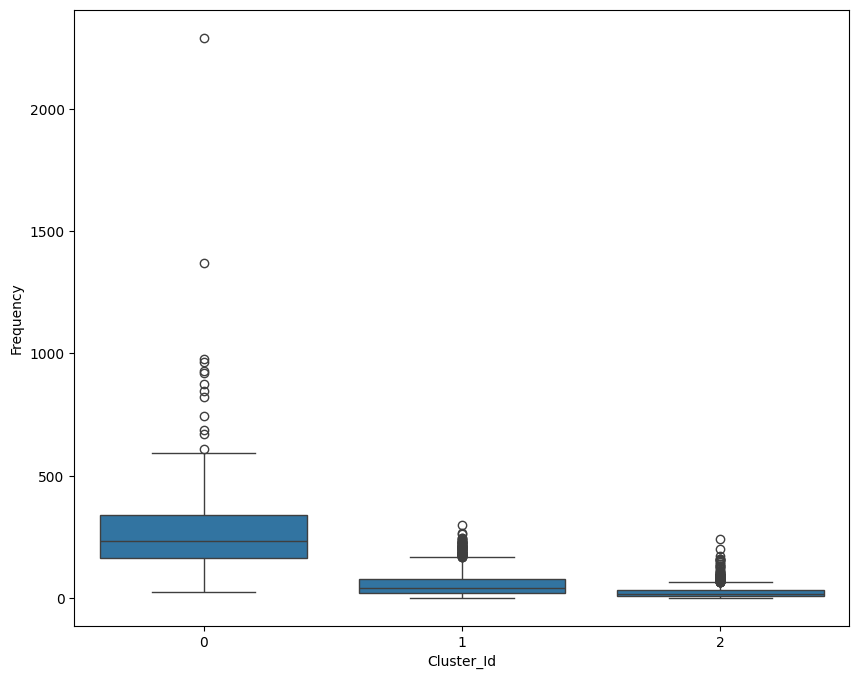

In [ ]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Recency'>

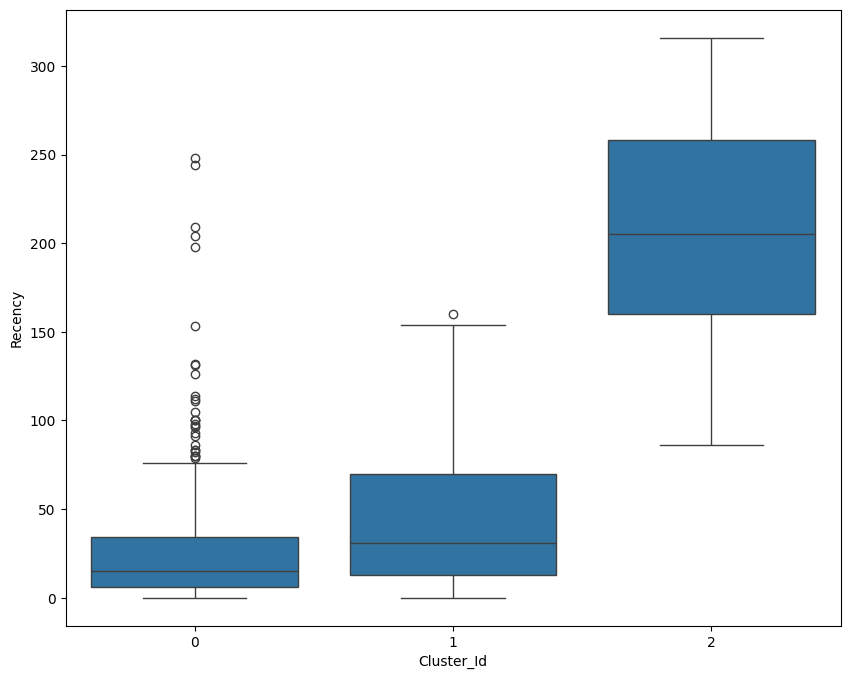

In [ ]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

### **Hierarchichal Clustering**

Hierarchical clustering is a method of cluster analysis that organizes data into a hierarchical structure, similar to the arrangement of files and folders on a hard disk. It consists of two main types: divisive, which starts with a single cluster and iteratively splits it, and agglomerative, which begins with each data point as its own cluster and merges them. Different linkage criteria further define the distance between clusters. Single linkage clustering calculates the shortest distance between any two points in the clusters, complete linkage measures the longest distance, and average linkage uses the average distance between points in the clusters. A dendrogram, a tree-like diagram, visualizes these clusters and helps in understanding the multi-level structure of the data. Following K-Means clustering, hierarchical clustering provides a complementary perspective by revealing nested clusters and offering a detailed view of customer segmentation. By examining the dendrogram, one can explore how customers are grouped at various levels of granularity, uncovering subgroups that may not be visible through K-Means alone. This combined approach enhances the ability to analyze and interpret customer data, revealing both broad and intricate patterns in behavior.

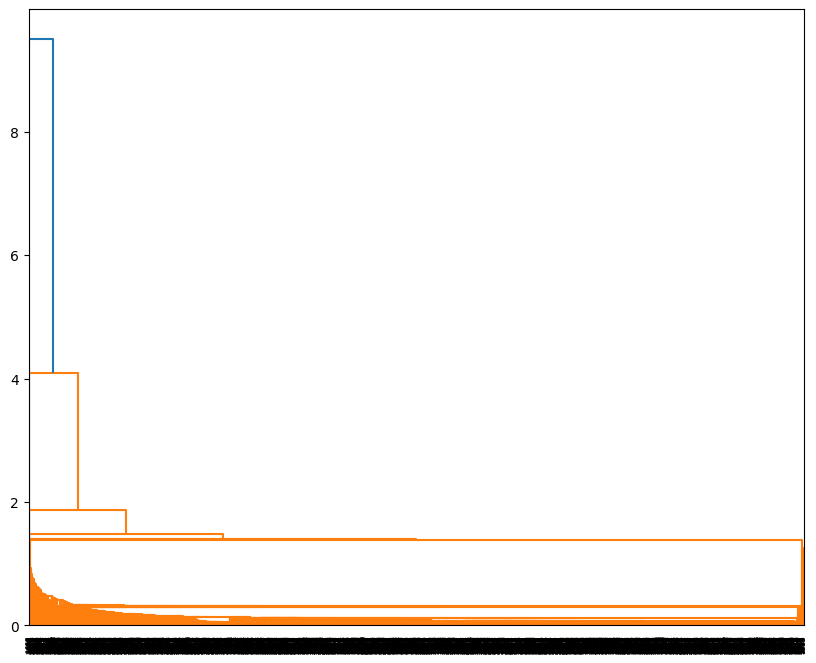

In [ ]:
# Single linkage:

mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

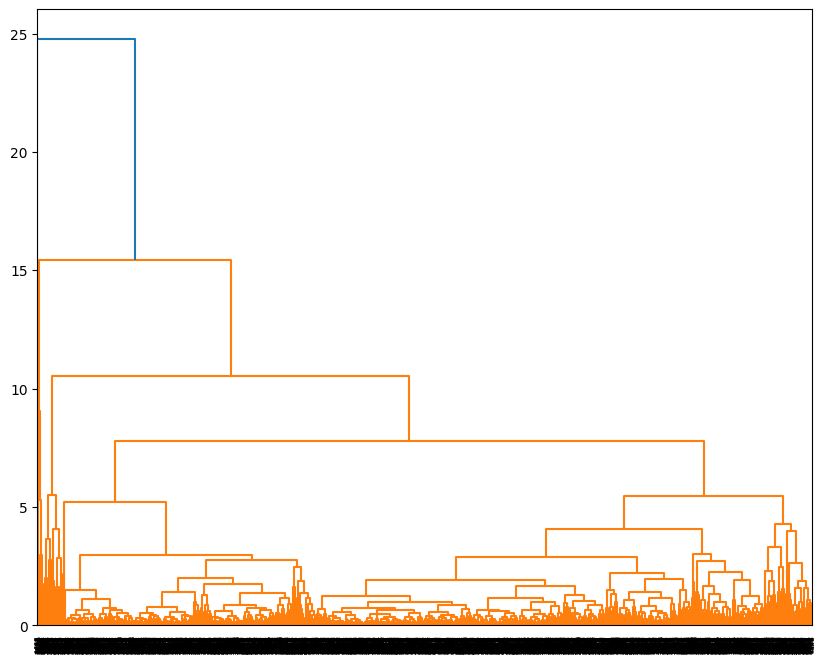

In [ ]:
# Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

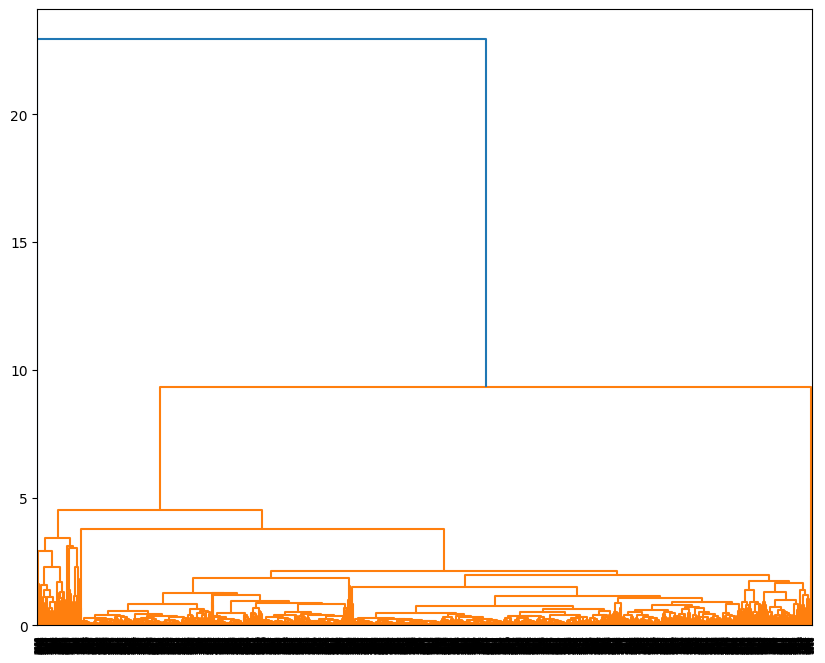

In [ ]:
# Average linkage

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

**Cutting the Dendogram based on K**

In [40]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

**Visualizing Cluster ID vs Amount, Frequency, and Recency(RFM) for Hierarchical Clustering**

In [41]:
# Assign cluster labels

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,12346.0,0.00,2,268,2,0
1,12347.0,2790.86,124,72,1,0
2,12348.0,1797.24,31,17,1,0
3,12350.0,334.40,17,252,2,0
4,12352.0,1233.68,80,14,1,0


<Axes: xlabel='Cluster_Labels', ylabel='Amount'>

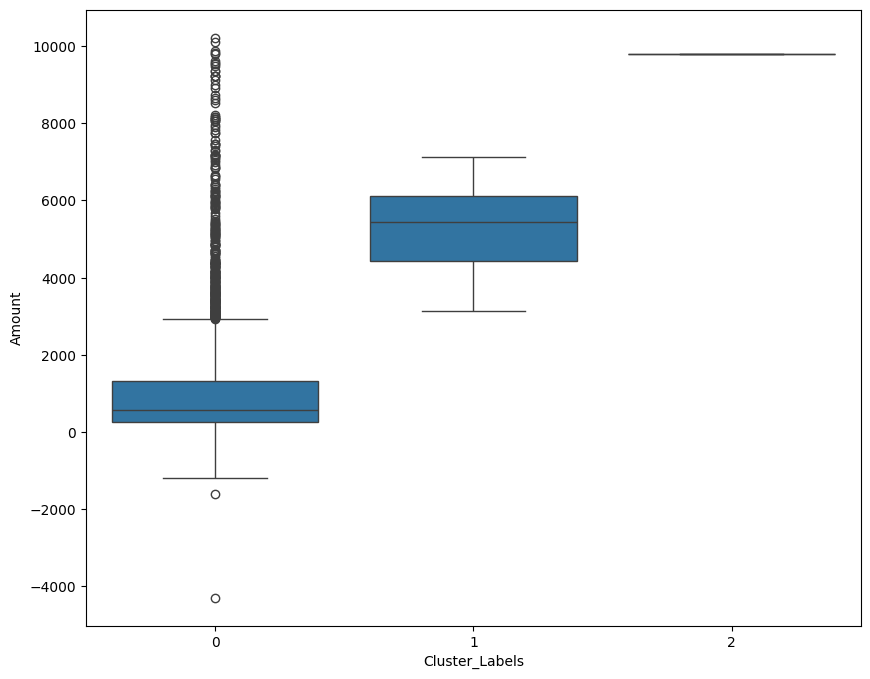

In [42]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Labels', ylabel='Frequency'>

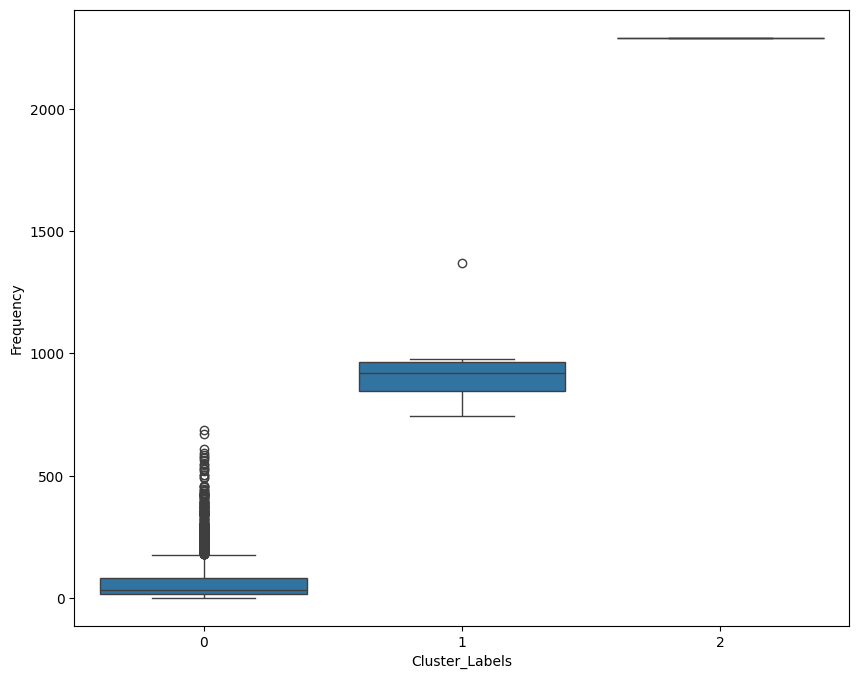

In [43]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Labels', ylabel='Recency'>

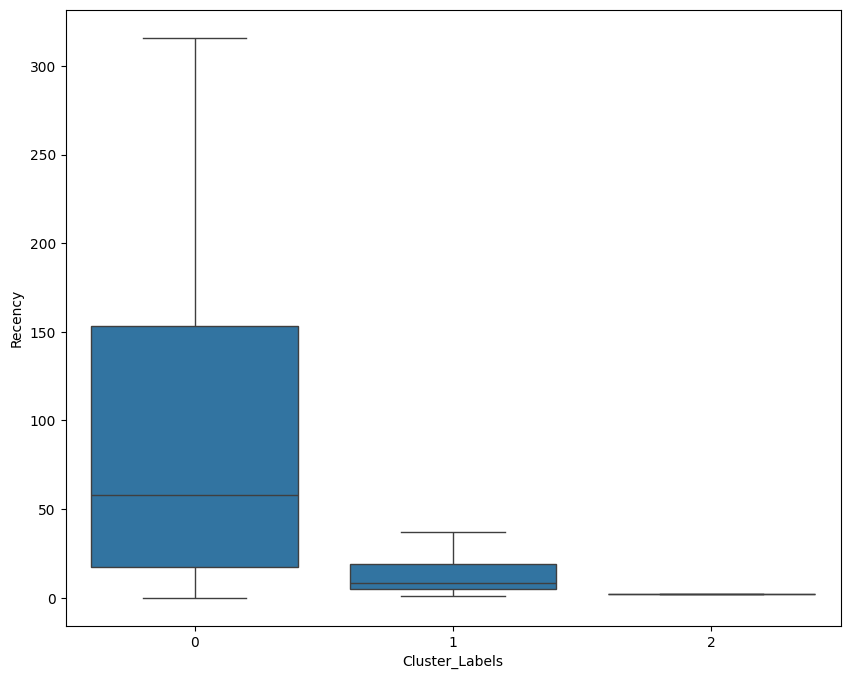

In [44]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

# **Analysis**

The final analysis delves into the interpretation of customer segments identified through both K-Means and Hierarchical Clustering techniques. For K-Means Clustering, which involved partitioning customers into three distinct clusters, Cluster 1 emerged as representing the most valuable customer group. These customers exhibit high transaction amounts and frequent purchase behavior, indicating their importance to the business. In contrast, Cluster 2 comprises customers who are less active, with fewer transactions and less frequent purchases, making them a lower priority for targeted business strategies. Hierarchical Clustering, applied with three cluster labels, reveals a similar distribution of customer segments but with slight variations in the grouping structure. Customers classified under Cluster_Labels 2 in Hierarchical Clustering also show high transaction volumes and frequent purchases, mirroring the K-Means Cluster 1 segment. On the other hand, customers in Cluster_Labels 0 are identified as less active, akin to the K-Means Cluster 2 segment. The comparative analysis of both clustering methods highlights the alignment of segmentations across the two approaches, providing a robust validation of the customer segmentation results. This dual-method validation enhances the overall understanding of the customer base, confirming the reliability of the identified segments and offering insights for more targeted and effective business strategies.

# **Conclusion**

The comprehensive analysis of customer segmentation using both K-Means and Hierarchical Clustering techniques provides valuable insights into customer behavior within the online retail dataset. K-Means Clustering effectively identifies three distinct customer segments, each with unique purchasing behaviors.

**K-Means Clustering Insights:**


*   Customers in Cluster 1, identified as high-value, demonstrate high transaction amounts and frequent purchases. This segment is crucial for the business due to their significant revenue contribution. Marketing strategies for these customers should focus on engagement and loyalty through personalized offers, exclusive promotions, and premium services.
*   In contrast, Cluster 2 comprises customers who exhibit less frequent purchasing and lower transaction volumes. This group is considered a lower priority for immediate marketing efforts. However, strategies to re-engage these customers, such as targeted campaigns or incentives, could potentially increase their activity and transaction amounts.

**Hierarchical Clustering Insights:**


*   Hierarchical Clustering results align with K-Means findings for high-value customers, with those in Cluster_Labels 2 showing similar transaction and purchase frequency patterns as K-Means Cluster 1. This consistency reinforces the accuracy of the high-value segment identified by K-Means.
*   Similarly, Cluster_Labels 0 in Hierarchical Clustering corresponds to K-Means Cluster 2, confirming the segmentation of less active customers. This alignment enhances the reliability of the segmentation results and supports the need for focused re-engagement strategies.


**Comparative Analysis**:


*   The comparison between K-Means and Hierarchical Clustering validates the segmentation results across different methods. K-Means provides a clear partitioned view, while Hierarchical Clustering offers a hierarchical perspective that reveals nested groupings. The agreement between the two methods strengthens confidence in the segmentation results and aids in developing targeted marketing strategies.




**Strategic Implications**:


*   Understanding the high-value customer segment allows for targeted marketing campaigns aimed at retention and loyalty. Personalized communications, loyalty rewards, and exclusive offers can be tailored to this group.
*   For less active customers, targeted re-engagement strategies are recommended. Special promotions and personalized outreach can address barriers to higher engagement and boost transaction frequency and value.
*   Effective resource allocation is another benefit of the segmentation analysis. By focusing marketing efforts on high-value customers and developing strategies to re-engage low-value ones, businesses can optimize their marketing spend and improve overall return on investment.








**Future Recommendations**:


*   Further segmentation analyses, incorporating geographic or demographic factors, could provide additional insights into customer behavior and preferences. Regular updates to the segmentation model are advised to capture evolving customer behaviors and maintain effective marketing strategies.

*   Integrating segmentation results into broader business strategies will align marketing efforts with customer needs and business objectives, driving long-term success. The dual-method approach underscores the importance of data-driven decision-making in understanding and engaging with diverse customer groups.



